In [2]:
import math
import random
import networkx as nx
import gurobipy as gp


def distance(x1,y1,x2,y2):
    """distance: euclidean distance between (x1,y1) and (x2,y2)"""
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

def make_data(n):
    """make_data: compute matrix distance based on euclidean distance"""
    V = range(1,n+1)
    x = dict([(i,random.random()) for i in V])
    y = dict([(i,random.random()) for i in V])
    
    c = {}
    points = []
    for i in V:
        points.append((x[i],y[i]))
        for j in V:
            if j > i:
                c[i,j] = distance(x[i],y[i],x[j],y[j])
    return V,c, points


In [3]:
n = 7
seed = 1
random.seed(seed)
V,c,points = make_data(n)
points

[(0.13436424411240122, 0.7887233511355132),
 (0.8474337369372327, 0.0938595867742349),
 (0.763774618976614, 0.02834747652200631),
 (0.2550690257394217, 0.8357651039198697),
 (0.49543508709194095, 0.43276706790505337),
 (0.4494910647887381, 0.762280082457942),
 (0.651592972722763, 0.0021060533511106927)]

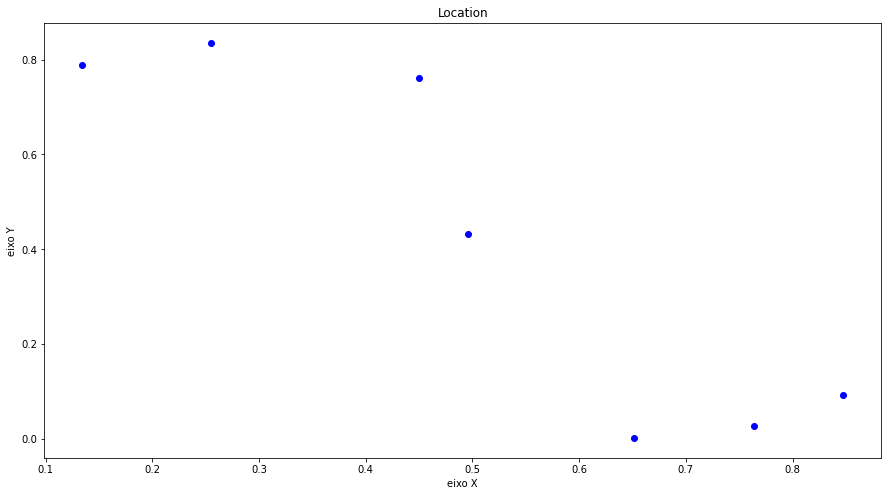

In [4]:
import matplotlib.pyplot as plt

X = [x[0] for x in points]
Y = [y[1] for y in points]


plt.figure(figsize=(15,8))
plt.scatter(X,Y,color='blue')

#for t in range(n):
#    plt.annotate(str(t), xy=(X[t],Y[t]), xytext = (X[t]+0.5, Y[t]+1), color='red')

plt.xlabel("eixo X")
plt.ylabel("eixo Y")
plt.title("Location")
plt.show()

In [10]:
def solve_tsp(V,c):
    """solve_tsp -- solve the traveling salesman problem 
       - start with assignment model
       - add cuts until there are no sub-cycles
    Parameters:
        - V: set/list of nodes in the graph
        - c[i,j]: cost for traversing edge (i,j)
    Returns the optimum objective value and the list of edges used.
    """
    
    def addcut(cut_edges):
        G = nx.Graph()
        G.add_edges_from(cut_edges)
        #Components = nx.simple_cycles(G)
        Components = nx.connected_components(G)

        if len(list(Components)) == 1:
            print("encontrou somente uma componente")
            return False
        
        for S in Components:
            print("componente maior que 1")
            if (len(S)<=n-1):
                model.addConstr(gp.quicksum(x[i,j] for i in S for j in S if j>i) <= len(S)-1)
                print("cut: len(%s) <= %s" % (S,len(S)-1))
        
        return True

    # main part of the solution process:
    model = gp.Model("tsp")

    model.Params.OutputFlag = 0 # silent/verbose mode
    
    x = {}
    for i in V:
        for j in V:
            if j > i:
                x[i,j] = model.addVar(ub=1, name="x(%s,%s)"%(i,j))
    model.update()
    
    for i in V:
        model.addConstr(gp.quicksum(x[j,i] for j in V if j < i) + gp.quicksum(x[i,j] for j in V if j > i) == 2, "degree(%s)"%i)
    
    model.setObjective(gp.quicksum(c[i,j]*x[i,j] for i in V for j in V if j > i), gp.GRB.MINIMIZE)

    edges = []
    for (i,j) in x:
        edges.append((i,j))

    addcut(edges)
    model.update()

    # all components connected, switch to integer model
    for (i,j) in x:     
        x[i,j].VType = "B"
    model.update()

    model.optimize()

    objval = model.ObjVal

    val_edges = []
    for (i,j) in x:
        if j > i:
            if x[i,j].X > 0.9:
                val_edges.append((i,j))

    return objval, val_edges

In [11]:
obj, edges = solve_tsp(V,c)

print("Optimal tour:", edges)
print("Optimal cost: ", round(obj,2))


NetworkXNotImplemented: not implemented for undirected type